In [1]:
import sys
sys.path.append("..")

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape

In [12]:
torch.cuda.is_available()

True

In [13]:
digits = datasets.load_digits()
X = digits['data']
y = digits['target']

J = []
for i in range(X.shape[0]):
    mask = np.ones((8,8))
    m_x = np.random.randint(0, 7)
    m_y = np.random.randint(0, 7)
    mask[m_y:m_y+2, m_x:m_x+2] = 0
    J.append(mask.reshape(-1))
    
J = np.vstack(J)
    
X = X / 16
X.shape, J.shape, y.shape, set(y)


((1797, 64), (1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [14]:
X_train, X_test, J_train, J_test, y_train, y_test = train_test_split(X, J, y, test_size=0.33, random_state=42)

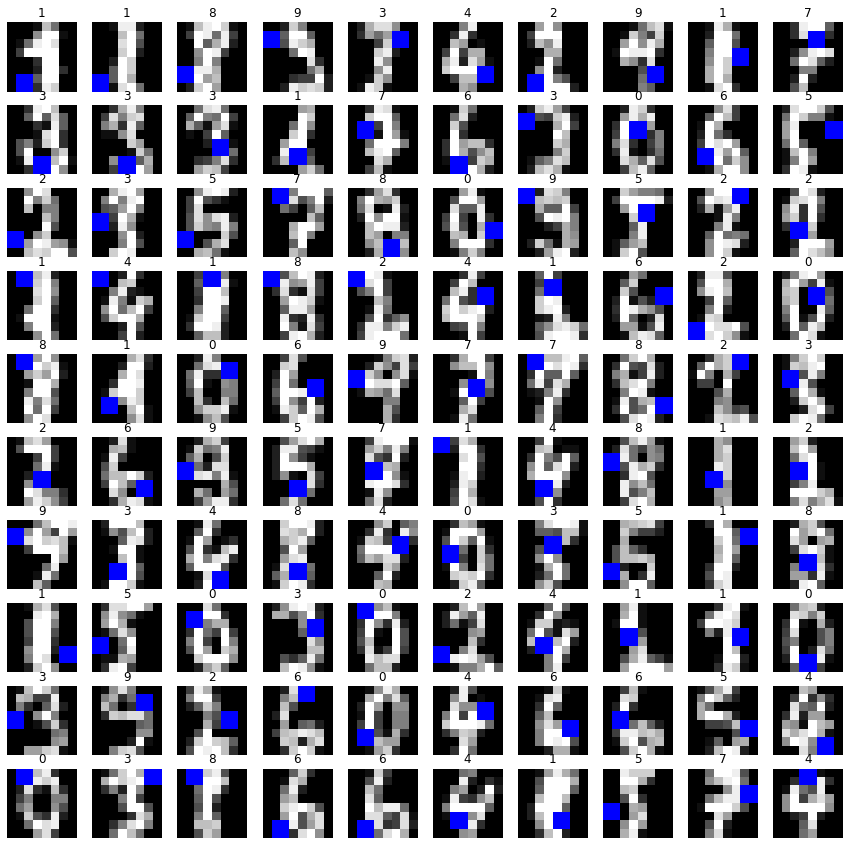

In [15]:
def vis_digit_mask(x, j, ax= None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    x_j = x *j
    vis = np.vstack([x_j, x_j, x_j + (j==0)]).T.reshape(8,8,3) 
    
    ax.imshow(vis)
    ax.axis("off")


fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y_train[i]}")
    vis_digit_mask(X_train[i], J_train[i],ax)

In [16]:
ds_train = TensorDataset(
    torch.Tensor(X_train), 
    torch.Tensor(J_train),
    torch.Tensor(y_train).long()
)

ds_test = TensorDataset(
    torch.Tensor(X_test), 
    torch.Tensor(J_test),
    torch.Tensor(y_test).long()
)

batch_size=16
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size, shuffle=True)

In [17]:
class DigitsInpainter(
    nn.Module
):
    def __init__(self, n_mixes: int = 1, in_size: int = 64, a_width = 3):
        super().__init__()

        extractor_out_size = 512
        self.extractor = nn.Sequential(
            nn.Linear(in_size * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, extractor_out_size),
            nn.ReLU()
        )
        
        self.a_extractor = nn.Sequential(
            nn.Linear(extractor_out_size, in_size * n_mixes * a_width),
            Reshape((-1, n_mixes, a_width, in_size,)) # * L, we don't want 1x4 vector but L x4 matrix))
        )
        self.m_extractor = nn.Sequential(
            nn.Linear(extractor_out_size, n_mixes * in_size),
            Reshape((-1, n_mixes, in_size)),
            nn.Sigmoid()

        )
        
        self.d_extractor = nn.Sequential(
            nn.Linear(extractor_out_size, n_mixes * in_size),
            Reshape((-1, n_mixes, in_size))

        )
        
        self.p_extractor = nn.Sequential(
            nn.Linear(extractor_out_size, n_mixes),
            nn.Softmax()
        ) # omit this, let's say p = 1 for now

    def forward(self, X, J):
        X_masked = X * J
        X_J = torch.cat([X_masked, J], dim=1)
        features = self.extractor(X_J)
        m = self.m_extractor(features)
        d = self.d_extractor(features)
        p = self.p_extractor(features)
        a = self.a_extractor(features)
        
        return  p, m, a, d

In [22]:

def nll_loss(X, J, P, M, A, D) -> torch.autograd.Variable:
    zipped = zip(X, J, P, M, A, D)
    losses = []
    
    
    for i, (x, j, p, m, a, d) in enumerate(zipped):
        mask_inds = (j==0).nonzero().squeeze()
        x_masked = torch.index_select(x, 0, mask_inds)
        a_masked = torch.index_select(a, 2, mask_inds)
        m_masked, d_masked = [
            torch.index_select(t, 1, mask_inds)
            for t in [m, d]
        ]
        
        for (p_i, m_i, d_i, a_i) in zip(p, m_masked, d_masked, a_masked):
            if a_i.shape[1] > 0:
                cov = (a_i.transpose(0, 1) @ a_i) + torch.diag(d_i ** 2)
                mvn_d = dist.MultivariateNormal(m_i, cov) # calculate this manually
                l = - mvn_d.log_prob(x_masked) 
                losses.append(l)
            else:
                losses.append(torch.autograd.Variable(torch.tensor(0.0), requires_grad=True))
    return torch.stack(losses).mean()

100%|██████████| 100/100 [18:00<00:00, 10.80s/it]


tensor(-2.2803, device='cuda:0', grad_fn=<MeanBackward0>)


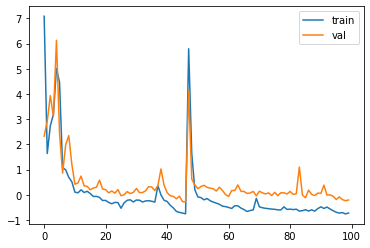

In [24]:
inpainter = DigitsInpainter()
inpainter = inpainter.cuda()
opt = optim.Adam(inpainter.parameters(), lr=4e-3)
n_epochs = 100
train_hist = []
val_hist = []
for e in tqdm(range(n_epochs)):
    inpainter.train()
    train_losses = [] 
    for i, (x, j, y) in enumerate(dl_train):
        inpainter.zero_grad()
        x, j = x.cuda(), j.cuda()
        p, m, a, d = inpainter(x, j)
        loss = nll_loss(x, j, p, m, a, d)
        loss.backward()
        opt.step()
        train_losses.append(loss)
    train_hist.append(torch.stack(train_losses).mean())
    
    inpainter.eval()
    val_losses = []
    for i, (x, j, y) in enumerate(dl_test):
        inpainter.zero_grad()
        x, j = x.cuda(), j.cuda()
        p, m, a, d = inpainter(x, j)
        loss = nll_loss(x, j, p, m, a, d)
        val_losses.append(loss)
    val_hist.append(torch.stack(val_losses).mean())

#     print(train_hist[-1], val_losses[-1])

plt.plot(list(range(n_epochs)), train_hist, label="train")
plt.plot(list(range(n_epochs)), val_hist, label="val")
plt.legend()
print(val_losses[-1])


In [26]:
classifier = MLPClassifier((100, 200, 10,), learning_rate_init=4e-3, max_iter=1000)
classifier.fit(X_train, y_train)
accuracy_score(classifier.predict(X_test), y_test)

0.9730639730639731

In [27]:
X_test_masked = X_test * J_test
accuracy_score(classifier.predict(X_test_masked), y_test)


0.8905723905723906

In [36]:
P_test, M_test, A_test, D_test = inpainter(torch.Tensor(X_test_masked).cuda(), torch.Tensor(J_test).cuda())

X_test_inpainted = X_test_masked.copy()
X_test_inpainted[J_test == 0] = M_test.detach().cpu().numpy()[:, 0][J_test == 0]

# print("X_test[0]", X_test[0]), 
# print("X_test_masked[0]", X_test_masked[0]) 
# print("M_test.detach().numpy()[0, 0]", M_test.detach().cpu().numpy()[0, 0]) 
# print("X_test_inpainted[0]", X_test_inpainted[0])
accuracy_score(classifier.predict(X_test_inpainted), y_test)

/home/marcin/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9545454545454546

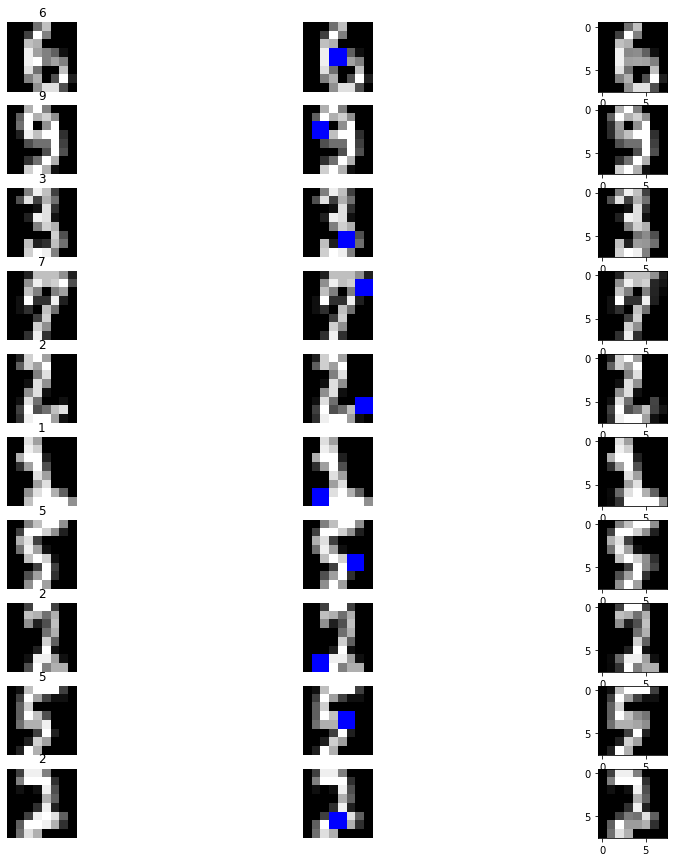

In [42]:
fig, axes = plt.subplots(10, 3, figsize=(15, 15))
for i in range(10):
    
    ax = axes[i, 0]
    ax.set_title(f"{y_test[i]}")
    ax.imshow(X_test[i].reshape(8,8), cmap="gray")
    ax.axis("off")
    vis_digit_mask(X_test[i], J_test[i], ax=axes[i, 1])
    
    ax = axes[i, 2]
    ax.imshow(X_test_inpainted[i].reshape(8,8), cmap="gray")
#     vis_digit_mask(X_train[i], J_train[i],ax)
    
plt.show()